# DGA Detection - Data Processing
# Exploratory Data Analysis (EDA)

In [65]:
%%capture
%pip install --upgrade pip
%pip install scikit-learn scipy numpy alibi tldextract pyarrow polaris

In [66]:
import polars as pl
import pandas as pd
import numpy as np

from scipy.stats import entropy
from fe_polars.encoding.target_encoding import TargetEncoder
from sklearn.model_selection import train_test_split 
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

## DGTA Benchmarking data set

We test our dataset with the DGTA Benchmark data set (https://data.mendeley.com/datasets/2wzf9bz7xr/1)

In [67]:
pd_dgta = pd.read_parquet("../data/dgta/dgta-benchmark.parquet")
pd_dgta

,domain,class
0,b'0dev.null.googlepages.com',legit
1,b'0.static.wix.com',legit
2,b'a2sportsguy.googlepages.com',legit
3,b'a2zexperts.googlepages.com',legit
4,b'a2zvs.setmore.com',legit
...,...,...
84943,b'adsunflower.com',legit
84945,b'meride.tv',legit
84947,b'sanalpazar.com',legit
84948,b'continular.com',legit


In [68]:
df_dgta = pl.read_parquet("../data/dgta/dgta-benchmark.parquet")
df_dgta = df_dgta.rename({"domain": "query"})
df_dgta = df_dgta.drop("__index_level_0__")
df_dgta

query,class
binary,str
[binary data],"""legit"""
[binary data],"""legit"""
[binary data],"""legit"""
[binary data],"""legit"""
[binary data],"""legit"""
[binary data],"""legit"""
[binary data],"""legit"""
[binary data],"""legit"""
[binary data],"""legit"""


In [69]:
def custom_decode(data):
    retL=[None] * len(data)
    for i, datum in enumerate(data):
        retL[i]=str(datum.decode('latin-1').encode('utf-8').decode('utf-8'))

    return(pl.Series(retL))

df_dgta = df_dgta.with_columns(
    [
        pl.col('query').map(custom_decode)
    ]
)
df_dgta

/tmp/ipykernel_165223/1026783953.py:10: DeprecationWarning: `map` is deprecated. It has been renamed to `map_batches`.
  pl.col('query').map(custom_decode)


query,class
str,str
"""0dev.null.goog…","""legit"""
"""0.static.wix.c…","""legit"""
"""a2sportsguy.go…","""legit"""
"""a2zexperts.goo…","""legit"""
"""a2zvs.setmore.…","""legit"""
"""aaa.bbb.ccc.co…","""legit"""
"""aaainfotech.go…","""legit"""
"""aaa.princeton.…","""legit"""
"""aaa.ssis.edu.v…","""legit"""


In [70]:
import math 

def entropy(string):
    "Calculates the Shannon entropy of a string"

    # get probability of chars in string
    prob = [ float(string.count(c)) / len(string) for c in dict.fromkeys(list(string)) ]

    # calculate the entropy
    entropy = - sum([ p * math.log(p) / math.log(2.0) for p in prob ])

    return entropy

print(f"Shannon Entropy of 0dev.null.googlepages.com: {entropy('0dev.null.googlepages.com')}")

Shannon Entropy of 0dev.null.googlepages.com: 3.6928786893420305


In [71]:
from string import ascii_lowercase as alc

df_dgta_processed = df_dgta.with_columns(
    [
        (pl.col("query").str.split(".").alias("labels")),
        (pl.col("query").str.split(".").list.len().alias("label_length")),
        (pl.col("query").str.split(".").list.max().str.len_chars().alias("label_max")),
        (pl.col("query").str.strip_chars(".").str.len_chars().alias("label_average")),
    ]
)
# Get letter frequency
for i in alc:
    df_dgta_processed = df_dgta_processed.with_columns(
        [
            (pl.col("query").str.to_lowercase().str.count_matches(rf"{i}").truediv(pl.col("query").str.len_chars())).alias(f"freq_{i}"),
        ]
    )

df_dgta_processed = df_dgta_processed.with_columns(
    [   
        # FQDN
        (pl.col("query")).alias("fqdn"),
        (pl.col("query").str.len_chars().alias("fqdn_full_count")),
        (pl.col("query").str.count_matches(r"[a-zA-Z]").truediv(pl.col("query").str.len_chars())).alias("fqdn_alpha_count"),
        (pl.col("query").str.count_matches(r"[0-9]").truediv(pl.col("query").str.len_chars())).alias("fqdn_numeric_count"),
        (pl.col("query").str.count_matches(r"[^\w\s]").truediv(pl.col("query").str.len_chars())).alias("fqdn_special_count"),
    ]
)
df_dgta_processed = df_dgta_processed.with_columns(
    [   
        # Second-level domain
        (pl.when(pl.col("labels").list.len() > 2)
            .then(
                pl.col("labels").list.get(-2)
            ).otherwise(
                pl.col("labels").list.get(0)
            ).alias("secondleveldomain")),
        (pl.when(pl.col("labels").list.len() > 2)
            .then(
                pl.col("labels").list.get(1).str.len_chars()
            ).otherwise(
                pl.col("labels").list.get(0).str.len_chars()
            ).alias("secondleveldomain_full_count")),
        (pl.when(pl.col("labels").list.len() > 2)
            .then(
                pl.col("labels").list.get(1).str.count_matches(r"[0-9]")
            ).otherwise(
                pl.col("labels").list.get(0).str.count_matches(r"[0-9]")
            ).alias("secondleveldomainn_numeric_count")),
        (pl.when(pl.col("labels").list.len() > 2)
            .then(
                pl.col("labels").list.get(1).str.count_matches(r"[^\w\s]")
            ).otherwise(
                pl.col("labels").list.get(0).str.count_matches(r"[^\w\s]")
            ).alias("secondleveldomain_special_count")),
    ]
)
df_dgta_processed = df_dgta_processed.with_columns(
    [   
        # Third-level domain
        (pl.when(pl.col("labels").list.len() > 2)
            .then(
               pl.col("labels").list.slice(0, pl.col("labels").list.len() - 2).list.join(".")
            ).otherwise(pl.lit("")).alias("thirdleveldomain")),
        (pl.when(pl.col("labels").list.len() > 2)
            .then(
                pl.col("labels").list.get(0).str.len_chars()
            ).otherwise(0).alias("thirdleveldomain_full_count")),
        (pl.when(pl.col("labels").list.len() > 2)
            .then(
                pl.col("labels").list.get(0).str.count_matches(r"[0-9]")
            ).otherwise(0).alias("thirdleveldomain_numeric_count")),
        (pl.when(pl.col("labels").list.len() > 2)
            .then(
                pl.col("labels").list.get(0).str.count_matches(r"[^\w\s]")
            ).otherwise(0).alias("thirdleveldomain_special_count")),
        
    ]
)

df_dgta_processed #.describe()

query,class,labels,label_length,label_max,label_average,freq_a,freq_b,freq_c,freq_d,freq_e,freq_f,freq_g,freq_h,freq_i,freq_j,freq_k,freq_l,freq_m,freq_n,freq_o,freq_p,freq_q,freq_r,freq_s,freq_t,freq_u,freq_v,freq_w,freq_x,freq_y,freq_z,fqdn,fqdn_full_count,fqdn_alpha_count,fqdn_numeric_count,fqdn_special_count,secondleveldomain,secondleveldomain_full_count,secondleveldomainn_numeric_count,secondleveldomain_special_count,thirdleveldomain,thirdleveldomain_full_count,thirdleveldomain_numeric_count,thirdleveldomain_special_count
str,str,list[str],u32,u32,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,u32,f64,f64,f64,str,u32,u32,u32,str,u32,u32,u32
"""0dev.null.goog…","""legit""","[""0dev"", ""null"", … ""com""]",4,4,25,0.04,0.0,0.04,0.04,0.12,0.0,0.12,0.0,0.0,0.0,0.0,0.12,0.04,0.04,0.12,0.04,0.0,0.0,0.04,0.0,0.04,0.04,0.0,0.0,0.0,0.0,"""0dev.null.goog…",25,0.84,0.04,0.12,"""googlepages""",4,0,0,"""0dev.null""",4,1,0
"""0.static.wix.c…","""legit""","[""0"", ""static"", … ""com""]",4,3,16,0.0625,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0625,0.0,0.0625,0.0,0.0,0.0,0.0625,0.125,0.0,0.0,0.0625,0.0625,0.0,0.0,"""0.static.wix.c…",16,0.75,0.0625,0.1875,"""wix""",6,0,0,"""0.static""",1,1,0
"""a2sportsguy.go…","""legit""","[""a2sportsguy"", ""googlepages"", ""com""]",3,11,27,0.074074,0.0,0.037037,0.0,0.074074,0.0,0.148148,0.0,0.0,0.0,0.0,0.037037,0.037037,0.0,0.148148,0.074074,0.0,0.037037,0.111111,0.037037,0.037037,0.0,0.0,0.0,0.037037,0.0,"""a2sportsguy.go…",27,0.888889,0.037037,0.074074,"""googlepages""",11,0,0,"""a2sportsguy""",11,1,0
"""a2zexperts.goo…","""legit""","[""a2zexperts"", ""googlepages"", ""com""]",3,11,26,0.076923,0.0,0.038462,0.0,0.153846,0.0,0.115385,0.0,0.0,0.0,0.0,0.038462,0.038462,0.0,0.115385,0.076923,0.0,0.038462,0.076923,0.038462,0.0,0.0,0.0,0.038462,0.0,0.038462,"""a2zexperts.goo…",26,0.884615,0.038462,0.076923,"""googlepages""",11,0,0,"""a2zexperts""",10,1,0
"""a2zvs.setmore.…","""legit""","[""a2zvs"", ""setmore"", ""com""]",3,7,17,0.058824,0.0,0.058824,0.0,0.117647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.117647,0.0,0.117647,0.0,0.0,0.058824,0.117647,0.058824,0.0,0.058824,0.0,0.0,0.0,0.058824,"""a2zvs.setmore.…",17,0.823529,0.058824,0.117647,"""setmore""",7,0,0,"""a2zvs""",5,1,0
"""aaa.bbb.ccc.co…","""legit""","[""aaa"", ""bbb"", … ""com""]",4,3,15,0.2,0.2,0.266667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""aaa.bbb.ccc.co…",15,0.8,0.0,0.2,"""ccc""",3,0,0,"""aaa.bbb""",3,0,0
"""aaainfotech.go…","""legit""","[""aaainfotech"", ""googlepages"", ""com""]",3,11,27,0.148148,0.0,0.074074,0.0,0.111111,0.037037,0.111111,0.037037,0.037037,0.0,0.0,0.037037,0.037037,0.037037,0.148148,0.037037,0.0,0.0,0.037037,0.037037,0.0,0.0,0.0,0.0,0.0,0.0,"""aaainfotech.go…",27,0.925926,0.0,0.074074,"""googlepages""",11,0,0,"""aaainfotech""",11,0,0
"""aaa.princeton.…","""legit""","[""aaa"", ""princeton"", ""edu""]",3,9,17,0.176471,0.0,0.058824,0.058824,0.117647,0.0,0.0,0.0,0.058824,0.0,0.0,0.0,0.0,0.117647,0.058824,0.058824,0.0,0.058824,0.0,0.058824,0.058824,0.0,0.0,0.0,0.0,0.0,"""aaa.princeton.…",17,0.882353,0.0,0.117647,"""princeton""",9,0,0,"""aaa""",3,0,0
"""aaa.ssis.edu.v…","""legit""","[""aaa"", ""ssis"", … ""vn""]",4,2,15,0.2,0.0,0.0,0.066667,0.066667,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.2,0.0,0.066667,0.066667,0.0,0.0,0.0,0.0,"""aaa.ssis.edu.v…",15,0.8,0.0,0.2,"""edu""",4,0,0,"""aaa.ssis""",3,0,0


In [72]:
for ent in ["fqdn", "thirdleveldomain", "secondleveldomain"]:
    df_dgta_processed = df_dgta_processed.with_columns(
        [   
            (pl.col(ent).map_elements(lambda x: [float(str(x).count(c)) / len(str(x)) for c in dict.fromkeys(list(str(x)))])).alias("prob"),
        ]
    )

    t =  math.log(2.0)

    df_dgta_processed = df_dgta_processed.with_columns(
        [   
            # - sum([ p * math.log(p) / math.log(2.0) for p in prob ])
            (pl.col("prob").list.eval(- pl.element() * pl.element().log() / t).list.sum()).alias(f"{ent}_entropy"),
        ]
    )
    df_dgta_processed = df_dgta_processed.drop("prob")
df_dgta_processed

query,class,labels,label_length,label_max,label_average,freq_a,freq_b,freq_c,freq_d,freq_e,freq_f,freq_g,freq_h,freq_i,freq_j,freq_k,freq_l,freq_m,freq_n,freq_o,freq_p,freq_q,freq_r,freq_s,freq_t,freq_u,freq_v,freq_w,freq_x,freq_y,freq_z,fqdn,fqdn_full_count,fqdn_alpha_count,fqdn_numeric_count,fqdn_special_count,secondleveldomain,secondleveldomain_full_count,secondleveldomainn_numeric_count,secondleveldomain_special_count,thirdleveldomain,thirdleveldomain_full_count,thirdleveldomain_numeric_count,thirdleveldomain_special_count,fqdn_entropy,thirdleveldomain_entropy,secondleveldomain_entropy
str,str,list[str],u32,u32,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,u32,f64,f64,f64,str,u32,u32,u32,str,u32,u32,u32,f64,f64,f64
"""0dev.null.goog…","""legit""","[""0dev"", ""null"", … ""com""]",4,4,25,0.04,0.0,0.04,0.04,0.12,0.0,0.12,0.0,0.0,0.0,0.0,0.12,0.04,0.04,0.12,0.04,0.0,0.0,0.04,0.0,0.04,0.04,0.0,0.0,0.0,0.0,"""0dev.null.goog…",25,0.84,0.04,0.12,"""googlepages""",4,0,0,"""0dev.null""",4,1,0,3.692879,2.947703,2.663533
"""0.static.wix.c…","""legit""","[""0"", ""static"", … ""com""]",4,3,16,0.0625,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0625,0.0,0.0625,0.0,0.0,0.0,0.0625,0.125,0.0,0.0,0.0625,0.0625,0.0,0.0,"""0.static.wix.c…",16,0.75,0.0625,0.1875,"""wix""",6,0,0,"""0.static""",1,1,0,3.32782,2.75,1.584963
"""a2sportsguy.go…","""legit""","[""a2sportsguy"", ""googlepages"", ""com""]",3,11,27,0.074074,0.0,0.037037,0.0,0.074074,0.0,0.148148,0.0,0.0,0.0,0.0,0.037037,0.037037,0.0,0.148148,0.074074,0.0,0.037037,0.111111,0.037037,0.037037,0.0,0.0,0.0,0.037037,0.0,"""a2sportsguy.go…",27,0.888889,0.037037,0.074074,"""googlepages""",11,0,0,"""a2sportsguy""",11,1,0,3.689892,3.277613,2.663533
"""a2zexperts.goo…","""legit""","[""a2zexperts"", ""googlepages"", ""com""]",3,11,26,0.076923,0.0,0.038462,0.0,0.153846,0.0,0.115385,0.0,0.0,0.0,0.0,0.038462,0.038462,0.0,0.115385,0.076923,0.0,0.038462,0.076923,0.038462,0.0,0.0,0.0,0.038462,0.0,0.038462,"""a2zexperts.goo…",26,0.884615,0.038462,0.076923,"""googlepages""",11,0,0,"""a2zexperts""",10,1,0,3.719295,3.121928,2.663533
"""a2zvs.setmore.…","""legit""","[""a2zvs"", ""setmore"", ""com""]",3,7,17,0.058824,0.0,0.058824,0.0,0.117647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.117647,0.0,0.117647,0.0,0.0,0.058824,0.117647,0.058824,0.0,0.058824,0.0,0.0,0.0,0.058824,"""a2zvs.setmore.…",17,0.823529,0.058824,0.117647,"""setmore""",7,0,0,"""a2zvs""",5,1,0,3.499228,2.321928,2.521641
"""aaa.bbb.ccc.co…","""legit""","[""aaa"", ""bbb"", … ""com""]",4,3,15,0.2,0.2,0.266667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""aaa.bbb.ccc.co…",15,0.8,0.0,0.2,"""ccc""",3,0,0,"""aaa.bbb""",3,0,0,2.42258,1.448816,0.0
"""aaainfotech.go…","""legit""","[""aaainfotech"", ""googlepages"", ""com""]",3,11,27,0.148148,0.0,0.074074,0.0,0.111111,0.037037,0.111111,0.037037,0.037037,0.0,0.0,0.037037,0.037037,0.037037,0.148148,0.037037,0.0,0.0,0.037037,0.037037,0.0,0.0,0.0,0.0,0.0,0.0,"""aaainfotech.go…",27,0.925926,0.0,0.074074,"""googlepages""",11,0,0,"""aaainfotech""",11,0,0,3.661933,3.027169,2.663533
"""aaa.princeton.…","""legit""","[""aaa"", ""princeton"", ""edu""]",3,9,17,0.176471,0.0,0.058824,0.058824,0.117647,0.0,0.0,0.0,0.058824,0.0,0.0,0.0,0.0,0.117647,0.058824,0.058824,0.0,0.058824,0.0,0.058824,0.058824,0.0,0.0,0.0,0.0,0.0,"""aaa.princeton.…",17,0.882353,0.0,0.117647,"""princeton""",9,0,0,"""aaa""",3,0,0,3.454822,0.0,2.947703
"""aaa.ssis.edu.v…","""legit""","[""aaa"", ""ssis"", … ""vn""]",4,2,15,0.2,0.0,0.0,0.066667,0.066667,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.2,0.0,0.066667,0.066667,0.0,0.0,0.0,0.0,"""aaa.ssis.edu.v…",15,0.8,0.0,0.2,"""edu""",4,0,0,"""aaa.ssis""",3,0,0,2.955913,1.811278,1.584963


Total number of classes 55


<BarContainer object of 2 artists>

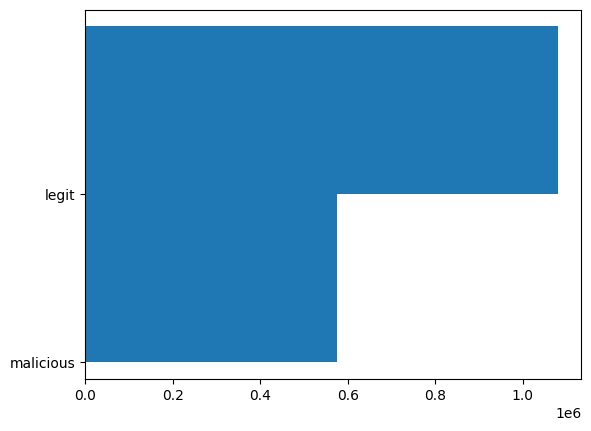

In [90]:
print(f"Total number of classes {len(df_dgta_processed['class'].value_counts())}")
# plt.barh(y=df_dgta.group_by("class").count()["class"], width=df_dgta.group_by("class").count()["count"], align='edge', height=1)

df_dgta_processed = df_dgta_processed.with_columns(
    [
        pl.when(pl.col("class") != "legit").then(pl.lit("malicious")).otherwise(pl.col("class")).alias("class")
    ]
)
df_dgta_classes = df_dgta_processed.group_by("class").count()
plt.barh(y=df_dgta_classes["class"], width=df_dgta_classes["count"], align='edge', height=1)

In [102]:
df_dataset = df_dgta_processed.drop(['query', 'labels', 'thirdleveldomain', 'secondleveldomain', 'fqdn'])
df_dataset = df_dataset.with_columns(pl.col("class").rank("dense").alias("class"))

cat_series = pl.Series('cat_series', df_dgta["class"]).cast(pl.Categorical)

X_train, X_test, Y_train, Y_test = train_test_split(
            df_dataset.drop("class"), 
            df_dataset.select("class"), 
            train_size=0.8, 
            random_state=42
        )

# target_encoder = TargetEncoder(smoothing=100, features_to_encode=["class"])
# print(X_train)
# x_train = target_encoder.fit_transform(x=X_train, y=Y_train)
# print(x_train)

# df_test['class'] = pl.Categorical(df_test['class'])
# df_test['class'] = df_test['class'].cat.codes

# df_without_label = df_test.drop(['class'])

shape: (2, 2)
┌───────┬─────────┐
│ class ┆ counts  │
│ ---   ┆ ---     │
│ u32   ┆ u32     │
╞═══════╪═════════╡
│ 1     ┆ 1080697 │
│ 2     ┆ 576537  │
└───────┴─────────┘


In [122]:
kmeans = KMeans(n_clusters=2, n_init=10)

kmeans.fit(X_train, Y_train)

y_pred = kmeans.predict(X_test)

y_true = Y_test
print(np.unique(y_pred))
print(np.unique(y_true))

y_true = np.where(y_true == 1, 0, y_true)
y_true = np.where(y_true == 2, 1, y_true)

[0 1]
[1 2]


In [123]:
print(classification_report(y_true, y_pred, labels=[*range(2)]))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80    215667
           1       1.00      0.07      0.14    115780

    accuracy                           0.68    331447
   macro avg       0.83      0.54      0.47    331447
weighted avg       0.78      0.68      0.57    331447



In [131]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier() # max_depth=15, random_state=0 -> TODO Hyperparam search!
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)

/home/smachmeier/projects/heiDGA/.venv/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [132]:
print(np.unique(Y_test))
print(np.unique(y_pred))
print(classification_report(Y_test, y_pred, labels=[1,2]))

[1 2]
[1 2]
              precision    recall  f1-score   support

           1       1.00      0.99      0.99    215667
           2       0.98      1.00      0.99    115780

    accuracy                           0.99    331447
   macro avg       0.99      0.99      0.99    331447
weighted avg       0.99      0.99      0.99    331447



In [114]:
print(f'Labels: {np.unique(y_true)}')

print(f'Malicious Requests: {np.count_nonzero(y_true == 1)}')
print(f'Benign Requests: {np.count_nonzero(y_true == 0)}')

Labels: [0 1]
Malicious Requests: 115780
Benign Requests: 215667


<Axes3D: title={'center': 'PCA'}, xlabel='Entropy', ylabel='FQDN_full_count', zlabel='Class'>

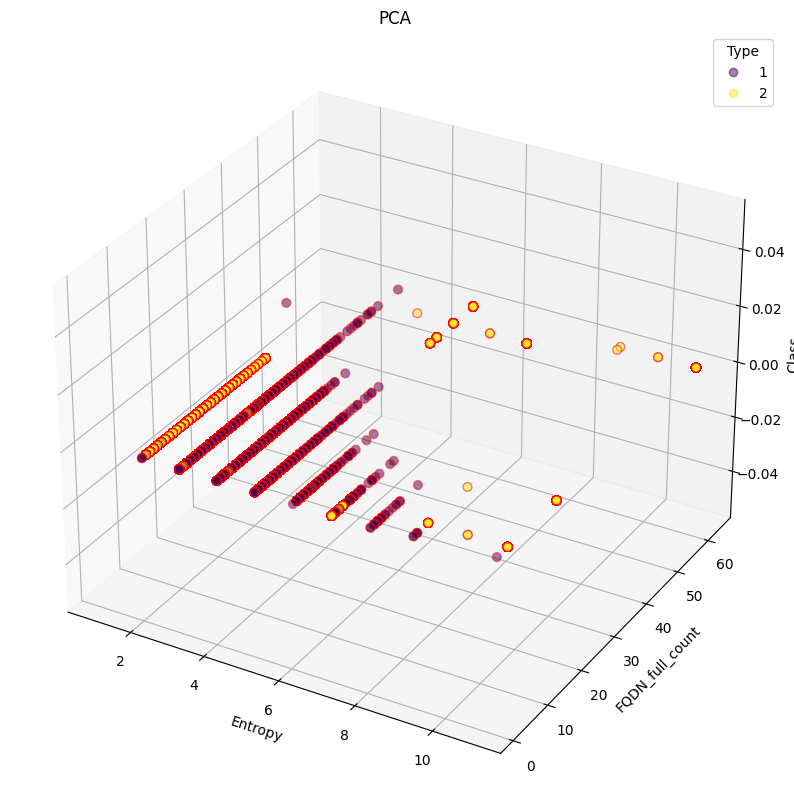

In [133]:
fig = plt.figure(figsize=(10,10))

fig = fig.add_subplot(111, projection='3d')
scatter = fig.scatter(X_test[:,0], X_test[:,1], c=y_pred, edgecolor='red', s=40, alpha = 0.5)

fig.set_title("PCA")
fig.set_xlabel("Entropy")
fig.set_ylabel("FQDN_full_count")
fig.set_zlabel("Class")
fig.legend(*scatter.legend_elements(), loc="upper right", title="Type")
fig